## Import libs

In [1]:
from math import sqrt, isnan
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.data import Dataset

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from util.dataset import Dataset as madras_Dataset
from util import read_data as rd
from util import metrics

from zhang.models import FairLogisticRegression, UnfairLogisticRegression

## Preliminaries

In [2]:
batch_size = 64
epochs = 10
lr = 0.001
opt = Adam(learning_rate=0.001)#, beta_1=0.95, beta_2=0.01)#learning_rate=learning_rate)#l
#opt = Adagrad(learning_rate=learning_rate)

## Load data

In [3]:
data_name = 'adult'

data_info = rd.return_data_info(data_name)
npzfile = rd.return_npz(data_name)

data = madras_Dataset(npzfile=npzfile, name=data_name, a0_name=data_info['a0_name'], a1_name=data_info['a1_name'], 
                use_a=data_info['use_a'], seed=data_info['seed'], batch_size=batch_size)

data_shapes = list(data.get_shapes())
#print(data_shapes)

xdim = data_shapes[0][1]
ydim = data_shapes[1][1]
adim = data_shapes[2][1]
zdim = 8

In [4]:
train_data = Dataset.from_tensor_slices((data.x_train, data.y_train, data.a_train))
train_data = train_data.batch(batch_size)
train_data

<BatchDataset shapes: ((None, 113), (None, 1), (None, 1)), types: (tf.float64, tf.float32, tf.float32)>

In [5]:
data.y_train[1:10]

array([[0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [6]:
valid_data = Dataset.from_tensor_slices((data.x_valid, data.y_valid, data.a_valid))
valid_data = valid_data.batch(batch_size)

In [7]:
data.y_valid.shape

(6016, 1)

In [8]:
test_data = Dataset.from_tensor_slices((data.x_test, data.y_test, data.a_test))
test_data = test_data.batch(batch_size)

## Train loop

In [9]:
def train(model, X, Y, A, optimizer, alpha=1):
    clas_vars = [model.clas.W, model.b]
    #print(model.clas.W)
    with tf.GradientTape() as clas_tape:
        
        model(X, Y, A) #to compute the foward
        
        clas_loss = model.clas_loss #current classifier loss

    dWLp = clas_tape.gradient(clas_loss, clas_vars) #adv_grads
    #print('dULa ', dULa)
    optimizer.apply_gradients(zip(dWLp, clas_vars))

In [34]:
def train_loop(model, train_dataset, epochs, optmizer):
    
    print("> Epoch | Class Loss | Class Acc")
    
    for epoch in range(epochs):
        Y_hat = None
        batch_count = 1
        lr = 0.001/(epoch+1)
        opt = Adam(learning_rate=lr)
        
        for X, Y, A in train_dataset:
            
            r = train(model, X, Y, A, opt)
            if r:
                print('parou')
                print(model.clas_loss)
                break

            if batch_count == 1:
                Y_hat = model.Y_hat
                batch_count += 1
            else:
                Y_hat = tf.concat([Y_hat, model.Y_hat], 0)

        clas_loss = model.clas_loss
        clas_acc = metrics.accuracy(data.y_train, tf.math.round(Y_hat))

        
    
        print("> {} | {} | {}".format(
            epoch+1, 
            clas_loss, 
            clas_acc))
        #print(model.clas.W)
        #print(Y_hat)

## Validation

In [11]:
def validation(model, valid_data):
    Y_hat = None
    batch_count = 1
    
    for X, Y, A in valid_data:
        
        model(X, Y, A)
        
        if batch_count == 1:
            Y_hat = model.Y_hat
            batch_count += 1
        else:
            Y_hat = tf.concat([Y_hat, model.Y_hat], 0)
    
    return Y_hat

In [38]:
def compute_metrics(Y, Y_hat, A):
    Y_hat = tf.math.round(Y_hat)
    
    clas_acc = metrics.accuracy(Y, Y_hat)

    print("> Class Acc")
    print("> {}".format(clas_acc))

    dp = metrics.DP(Y_hat.numpy(), A)
    di = metrics.DI(Y, Y_hat.numpy(), A)
    deopp = metrics.DI_soft(Y, Y_hat.numpy(), A)

    print("> DP | DI | DEOPP")
    print("> {} | {} | {}".format(dp, di, deopp))

    tp = metrics.TP(Y, Y_hat.numpy())
    tn = metrics.TN(Y, Y_hat.numpy())
    fp = metrics.FP(Y, Y_hat.numpy())
    fn = metrics.FN(Y, Y_hat.numpy())

    print('> Confusion Matrix \n' +
                'TN: {} | FP: {} \n'.format(tn, fp) +
                'FN: {} | TP: {}'.format(fn, tp))

    confusion_matrix = np.array([[tn, fp],
                                [fn, tp]])

    m = [metrics.TN, metrics.FP, metrics.FN, metrics.TP]
    metrics_a0 = [0, 0, 0, 0]
    metrics_a1 = [0, 0, 0, 0]
    for i in range(len(metrics_a0)):
        metrics_a0[i] = metrics.subgroup(m[i], A, Y, Y_hat.numpy())
        metrics_a1[i] = metrics.subgroup(m[i], 1 - A, Y, Y_hat.numpy())

    print('> Confusion Matrix for A = 0 \n' +
            'TN: {} | FP: {} \n'.format(metrics_a0[0], metrics_a0[1]) +
            'FN: {} | TP: {}'.format(metrics_a0[2], metrics_a0[3]))

    print('> Confusion Matrix for A = 1 \n' +
            'TN: {} | FP: {} \n'.format(metrics_a1[0], metrics_a1[1]) +
            'FN: {} | TP: {}'.format(metrics_a1[2], metrics_a1[3]))

    confusion_matrix = np.array([[tn, fp],
                                [fn, tp]])

    return clas_acc, confusion_matrix

## Testing if models are being trained

### For DP

In [35]:
model = UnfairLogisticRegression(xdim, batch_size)
ret = train_loop(model, train_data, 100, opt)

> Epoch | Class Loss | Class Acc
> 1 | 0.5808563232421875 | 0.7526525198938991
> 2 | 0.5149173140525818 | 0.8006051061007957
> 3 | 0.45487380027770996 | 0.816520225464191
> 4 | 0.4417272210121155 | 0.8286223474801061
> 5 | 0.43262624740600586 | 0.8345905172413793
> 6 | 0.4257793128490448 | 0.8373259283819628
> 7 | 0.420637845993042 | 0.8396468832891246
> 8 | 0.4162589907646179 | 0.8409731432360743
> 9 | 0.41210657358169556 | 0.8425480769230769
> 10 | 0.4092973470687866 | 0.8434184350132626
> 11 | 0.40705162286758423 | 0.84375
> 12 | 0.40481358766555786 | 0.8440815649867374
> 13 | 0.4029082953929901 | 0.8449519230769231
> 14 | 0.4012395143508911 | 0.8452005968169761
> 15 | 0.39977315068244934 | 0.8457808355437666
> 16 | 0.39844000339508057 | 0.8457808355437666
> 17 | 0.3972230553627014 | 0.8459880636604775
> 18 | 0.3960703909397125 | 0.8459880636604775
> 19 | 0.3949980139732361 | 0.8459051724137931
> 20 | 0.39399686455726624 | 0.8462367374005305
> 21 | 0.3930594325065613 | 0.84648541114

In [39]:
Y_hat = validation(model, valid_data)
ret = compute_metrics(data.y_valid, Y_hat, data.a_valid)

> Class Acc
> 0.844248670212766
> DP | DI | DEOPP
> 0.2039434313774109 | 0.1251106560230255 | 0.07995763421058655
> Confusion Matrix 
TN: 4179.0 | FP: 314.0 
FN: 623.0 | TP: 900.0
> Confusion Matrix for A = 0 
TN: 1689.0 | FP: 24.0 
FN: 118.0 | TP: 98.0
> Confusion Matrix for A = 1 
TN: 2490.0 | FP: 290.0 
FN: 505.0 | TP: 802.0


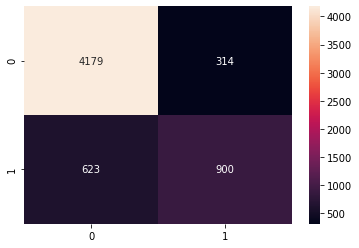

In [37]:
sns.heatmap(ret[1], annot=True, fmt='g')